# House Price Analysis with Linear Regression - Models and Predictions

---
___
***

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action= 'ignore', category= UserWarning)

#code to display all the columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/df_features_clean')

## Modeling and Prediction

### Feature Selection

Check correlation among features again. Making sure not to pick features with a strong correlation to each other to avoid multicollinearity.


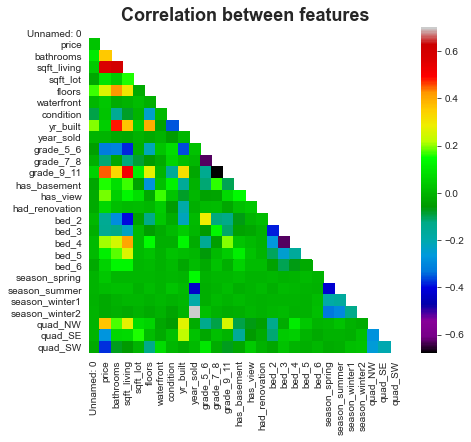

In [3]:
corr = df.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df.corr(), cmap= 'nipy_spectral', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

Let's see which features have the highest correlations.

In [4]:
df_corr_stack = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr_stack['pairs'] = list(zip(df_corr_stack.level_0, df_corr_stack.level_1))

df_corr_stack.set_index(['pairs'], inplace= True)

df_corr_stack.drop(columns= ['level_1', 'level_0'], inplace= True)
df_corr_stack.columns = ['cc']

df_corr_stack.drop_duplicates(inplace= True)

df_corr_stack[(df_corr_stack.cc > .55) & (df_corr_stack.cc < 1)]

,cc
pairs,
"(season_winter2, year_sold)",0.702430
"(grade_9_11, grade_7_8)",0.678661
"(bed_4, bed_3)",0.629682
"(grade_7_8, grade_5_6)",0.626479
"(bathrooms, sqft_living)",0.604185
"(sqft_living, price)",0.574037


In [5]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [6]:
y = df['price']
X = df.drop('price', axis= 1)

result = stepwise_selection(X, y)
print ('resulting features:')
print (result)

<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  bathrooms                      with p-value 0.0
Add  quad_SW                        with p-value 0.0
Add  grade_9_11                     with p-value 0.0
Add  sqft_living                    with p-value 0.0


<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


ValueError: list.remove(x): x not in list

The stepwise selection function suggested the following features:


|           |            |           |                |
|-----------|------------|-----------|----------------|
|grade_5_6  | yr_built   | quad_SW   | condition      |
|grade_7_8  | year_sold  | quad_SE   |  floors        |
|grade_9_11 |  bed_2     | quad_NW   |  bathrooms     |
|sqft_living|  bed_5     |waterfront | had_renovation |
|sqft_lot   |  bed_6     |  has_view | season_winter2 | 

### Model 1

In [11]:
model1_df = df[['price', 'has_view', 'condition', 'waterfront', 'floors', 
                'year_sold', 'grade_5_6', 'grade_9_11', 
                'quad_SE', 'quad_SW', 'yr_built', 'sqft_living', 
                'bathrooms', 'bed_5', 'bed_2', 'had_renovation', 'has_view', 
                'sqft_lot', 'season_winter2']]

In [12]:
outcome = 'price'
x_cols = model1_df.drop(columns= ['price'], axis= 1)

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula = f, data= model1_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     2349.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        19:14:10   Log-Likelihood:            -2.5014e+05
No. Observations:               19305   AIC:                         5.003e+05
Df Residuals:                   19287   BIC:                         5.005e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -5.122e+07   4.47e+06    -11.457      0.000      -6e+07   -4.25e+07
has_view[0]     2.968e+04   1525.963     19.450      0.000    2.67e+04    3.27e+04
has_view[1]     2.968e+04   1525.963     19.450      0.000    2.67e+04    3.27e+04
condition       2.387e+04   1263.931     18.887      0.000    2.14e+04    2.63e+04
waterfront      1.824e+05   1.66e+04     11.012      0.000     1.5e+05    2.15e+05
floors          2.381e+04   1535.950     15.502      0.000    2.08e+04    2.68e+04
year_sold       2.638e+04   2219.311     11.888      0.000     2.2e+04    3.07e+04
grade_5_6      -7.561e+04   2669.225    -28.325      0.000   -8.08e+04   -7.04e+04
grade_9_11      1.038e+05   2663.985     38.969      0.000    9.86e+04    1.09e+05
quad_SE        -1.699e+05   2101.506    -80.829      0.000   -1.74e+05   -1.66e+05
quad_SW        -1.935e+05   2139.584    -90.439      0.000   -1.98e+05   -1.89e+05
yr_built        -896.9118     35.706    -25.120      0.000    -966.898    -826.926
sqft_living      110.7251      1.615     68.577      0.000     107.560     113.890
bathrooms       1.172e+04   1641.905      7.140      0.000    8504.552    1.49e+04
bed_5          -2.539e+04   3263.239     -7.780      0.000   -3.18e+04    -1.9e+04
bed_2           1.186e+04   2395.130      4.951      0.000    7163.231    1.66e+04
had_renovation  3.052e+04   4612.418      6.618      0.000    2.15e+04    3.96e+04
sqft_lot           0.2997      0.023     12.864      0.000       0.254       0.345
season_winter2 -1.667e+04   2635.405     -6.326      0.000   -2.18e+04   -1.15e+04
==============================================================================
Omnibus:                      741.131   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1201.475
Skew:                           0.345   Prob(JB):                    1.27e-261
Kurtosis:                       4.009   Cond. No.                     1.14e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.87e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Model 1: Q-Q Plot

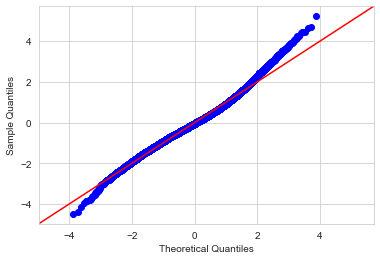

In [13]:
# Q-Q plot
residuals = model.resid
fig1 = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig1.show()

#### RMSE 

#### Train, Test Split

In [14]:
# outcome = 'price'
# x_cols = model1_df.drop(columns= ['price', 'condition'], axis= 1)

# predictors = '+'.join(x_cols)
# f = outcome + '~' + predictors
# model = ols(formula = f, data= model1_df).fit()

# model.summary()

### Model 2: Log Transform Model 1 

In [15]:
model2_df = model1_df.copy()

In [16]:
model2_df.columns

Index(['price', 'has_view', 'condition', 'waterfront', 'floors', 'year_sold',
       'grade_5_6', 'grade_9_11', 'quad_SE', 'quad_SW', 'yr_built',
       'sqft_living', 'bathrooms', 'bed_5', 'bed_2', 'had_renovation',
       'has_view', 'sqft_lot', 'season_winter2'],
      dtype='object')

In [17]:
# list of continuous features to log transform them
cont = ['yr_built', 'sqft_living', 'sqft_lot']

In [18]:
df_cont = model2_df[cont]

log_names = [f'{column}_log' for column in df_cont.columns]

model2_log = np.log(df_cont)
model2_log.columns = log_names

def normalize(feature):
    return (feature - feature.mean() / feature.std())

model2_log_norm = model2_log.apply(normalize)

In [19]:
model2_log = pd.concat([model2_log_norm, model2_df], axis= 1)
model2_log.head()

,yr_built_log,sqft_living_log,sqft_lot_log,price,has_view,condition,waterfront,floors,year_sold,grade_5_6,grade_9_11,quad_SE,quad_SW,yr_built,sqft_living,bathrooms,bed_5,bed_2,had_renovation,has_view,sqft_lot,season_winter2
0,-505.621556,-12.508723,-1.457333,221900.0,0,3,0,1,2014,0,0,0,0,1955,1180,1,0,0,0,0,5650,0
1,-505.623605,-11.730332,-1.209091,538000.0,0,3,0,2,2014,0,0,0,0,1951,2570,2,0,0,1,0,7242,0
2,-505.632873,-12.935602,-0.886403,180000.0,0,3,0,1,2015,1,0,0,0,1933,770,1,0,1,0,0,10000,1
3,-505.616454,-12.001293,-1.579550,604000.0,0,5,0,1,2014,0,0,0,0,1965,1960,3,0,0,0,0,5000,0
4,-505.605321,-12.155444,-1.099596,510000.0,0,3,0,1,2015,0,0,0,0,1987,1680,2,0,0,0,0,8080,1


In [20]:
model2_log.drop(columns= ['yr_built', 'sqft_living', 'sqft_lot'], 
                inplace= True)

In [21]:
X = model2_log.drop('price', axis= 1)
y = model2_log['price']

X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     2312.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        19:14:24   Log-Likelihood:            -2.5025e+05
No. Observations:               19305   AIC:                         5.005e+05
Df Residuals:                   19287   BIC:                         5.007e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -9.458e+08   3.59e+07    -26.340      0.000   -1.02e+09   -8.75e+08
yr_built_log    -1.771e+06   7.05e+04    -25.131      0.000   -1.91e+06   -1.63e+06
sqft_living_log  2.003e+05   3183.330     62.908      0.000    1.94e+05    2.06e+05
sqft_lot_log     9354.3955   1017.964      9.189      0.000    7359.098    1.13e+04
has_view         3.136e+04   1530.586     20.488      0.000    2.84e+04    3.44e+04
condition        2.241e+04   1271.170     17.629      0.000    1.99e+04    2.49e+04
waterfront        1.74e+05   1.67e+04     10.442      0.000    1.41e+05    2.07e+05
floors           2.566e+04   1639.397     15.654      0.000    2.24e+04    2.89e+04
year_sold        2.637e+04   2231.335     11.816      0.000     2.2e+04    3.07e+04
grade_5_6       -6.029e+04   2759.433    -21.848      0.000   -6.57e+04   -5.49e+04
grade_9_11       1.207e+05   2600.277     46.418      0.000    1.16e+05    1.26e+05
quad_SE           -1.7e+05   2152.778    -78.974      0.000   -1.74e+05   -1.66e+05
quad_SW         -1.961e+05   2172.887    -90.262      0.000      -2e+05   -1.92e+05
bathrooms        1.519e+04   1644.911      9.237      0.000     1.2e+04    1.84e+04
bed_5           -1.711e+04   3256.051     -5.254      0.000   -2.35e+04   -1.07e+04
bed_2            2.694e+04   2466.915     10.920      0.000    2.21e+04    3.18e+04
had_renovation   2.989e+04   4636.934      6.446      0.000    2.08e+04     3.9e+04
has_view         3.136e+04   1530.586     20.488      0.000    2.84e+04    3.44e+04
season_winter2  -1.665e+04   2649.603     -6.285      0.000   -2.18e+04   -1.15e+04
==============================================================================
Omnibus:                      678.176   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1034.535
Skew:                           0.339   Prob(JB):                    2.26e-225
Kurtosis:                       3.909   Cond. No.                     5.05e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.26e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

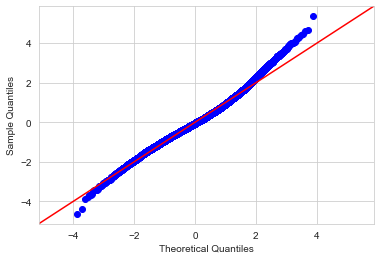

In [22]:
# Q-Q plot
residuals = model.resid
fig2 = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig2.show()

#### Train, test split

In [30]:
# X = model2_log.drop('price', axis= 1)
# y = model2_log['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 42)

In [31]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [32]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_mse)
print ('Test RMSE: ', test_rmse)

Train RMSE:  10651869970.893148
Test RMSE:  102482.49581479371
